# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product
import random

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    summarize_cell_data,
    plot_feature_distributions,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

random.seed(42)

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL_1`: First well identifier used for testing configuration
- `TEST_WELL_2`: Second well identifier used for testing configuration

In [3]:
TEST_PLATE = 1
TEST_WELL_1 = "A1"
TEST_WELL_2 = "A2"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_1}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=25000)

merge_final_fp_2 = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_2}, "merge_final", "parquet")
)
cell_data_2 = load_parquet_subset(merge_final_fp_2, n_rows=25000)

cell_data = pd.concat([cell_data, cell_data_2], ignore_index=True)
cell_data

Reading first 25,000 rows from /lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet
Reading first 25,000 rows from /lab/cheeseman_ops/brieflow-screens/denali-analysis/analysis/analysis_root/merge/parquets/P-1_W-A2__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,437,1478.403947,1481.714474,243,265,100.607843,670.117647,...,0,0.000000,48.564099,54.586397,164.116340,0,0.000000,48.615252,55.257173,159.483845
1,1,A1,401,494,1477.766431,1478.877654,101,302,100.089552,669.910448,...,1,0.065657,45.153871,62.255752,106.221846,1,0.037791,40.275758,56.068075,115.752777
2,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
3,1,A1,595,482,1480.676399,1482.874696,154,228,100.764706,670.764706,...,2,0.229299,37.000701,51.898329,172.518929,2,0.068627,38.735022,47.030219,157.402576
4,1,A1,1479,613,1477.695030,1481.850904,365,352,99.764045,671.494382,...,0,0.000000,57.800029,61.225938,139.073759,0,0.000000,62.404446,63.974515,134.672172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A2,479,550,1377.804974,1644.384817,130,207,74.261364,141.511364,...,0,0.000000,66.199311,77.392425,78.189224,0,0.000000,64.321929,84.153113,70.513449
49996,1,A2,1150,458,1563.914474,1654.427632,276,1599,691.465116,145.581395,...,1,0.176056,36.250410,63.546818,169.147891,1,0.103306,33.812472,63.261501,169.802120
49997,1,A2,380,500,1354.049871,1332.994841,91,1769,638.181159,634.260870,...,1,0.323442,52.928381,72.051040,89.042585,1,0.170686,57.124863,67.092077,80.896852
49998,1,A2,670,408,1287.338771,1461.084285,165,84,50.992063,95.230159,...,0,0.000000,73.861108,81.340320,72.063358,0,0.000000,77.916618,78.137105,65.943405


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
sgRNA_0
gene_symbol_0
mapped_single_gene
channels_min
nucleus_DAPI_int
nucleus_COXIV_int
nucleus_CENPA_int
nucleus_WGA_int
nucleus_DAPI_mean
nucleus_COXIV_mean
nucleus_CENPA_mean
nucleus_WGA_mean
nucleus_DAPI_std
nucleus_COXIV_std
nucleus_CENPA_std
nucleus_WGA_std
nucleus_DAPI_max
nucleus_COXIV_max
nucleus_CENPA_max
nucleus_WGA_max
nucleus_DAPI_min
nucleus_COXIV_min
nucleus_CENPA_min
nucleus_WGA_min
nucleus_DAPI_int_edge
nucleus_COXIV_int_edge
nucleus_CENPA_int_edge
nucleus_WGA_int_edge
nucleus_DAPI_mean_edge
nucleus_COXIV_mean_edge
nucleus_CENPA_mean_edge
nucleus_WGA_mean_edge
nucleus_DAPI_std_edge
nucleus_COXIV_std_edge
nucleus_CENPA_std_edge
nucleus_WGA_std_edge
nucleus_DAPI_max_edge
nucleus_COXIV_max_edge
nucleus_CENPA_max_edge
nucleus_WGA_max_edge
nucleus_DAPI_min_edge
nucleus_COXIV_min_edge
nucleus_CENPA_min_edge
nucleus_WGA_min_edge
nucleus_DAPI_mass_displacement
nucleus_COXIV_mass_displace

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "sgRNA_0",
    "gene_symbol_0",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

Split data: 35 metadata columns, 1649 feature columns
(50000, 35) (50000, 1649)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Columns to collapse on when creating a summary of cell counts.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`

**Note**: You must import necessary packages for the classifier here and add them to `scripts/aggregate/split_datasets.py` as well.

In [8]:
CLASSIFIER_PATH = "config/binary_xgb_robust_model.dill"
MONTAGE_CHANNEL = "DAPI"
COLLAPSE_COLS = ["sgRNA_0", "gene_symbol_0"]

import numpy as np

Removing 1078 rows with NaN values in features
Cell class counts:
class
interphase    48182
mitotic         740
Name: count, dtype: int64

Cell class confidences:


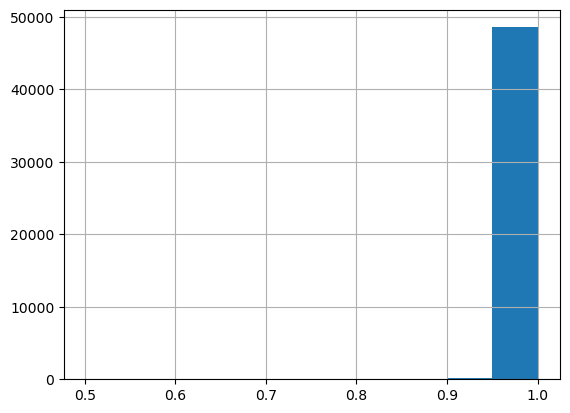

In [9]:
classifier = CellClassifier.load(CLASSIFIER_PATH)
metadata, features = classifier.classify_cells(metadata, features)

# Create config var for cell classes
CELL_CLASSES = list(metadata["class"].unique())

# Show cell class counts and distribution
print("Cell class counts:")
print(metadata["class"].value_counts())

print("\nCell class confidences:")
metadata["confidence"].hist()
plt.show()

Montages of cell classes:


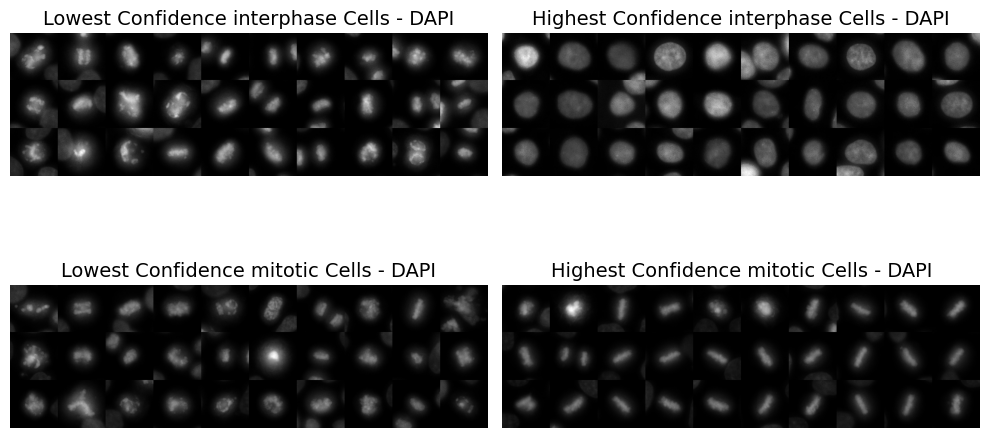

Split cell data summary:


,Stage,Count,Percent
0,Raw Data,48922,100.00
1,interphase cells,48182,98.49
2,interphase sgRNA_0,9400,19.21
3,interphase gene_symbol_0,4540,9.28
4,mitotic cells,740,1.51
5,mitotic sgRNA_0,163,0.33
6,mitotic gene_symbol_0,160,0.33


In [10]:
cell_classes = list(metadata["class"].unique()) + ["all"]

classified_metadata = metadata.copy(deep=True)
classified_metadata = add_filenames(classified_metadata, ROOT_FP)

# Create a dictionary of DataFrames for each cell class
cell_class_dfs = {
    cell_class: classified_metadata[classified_metadata["class"] == cell_class]
    for cell_class in CELL_CLASSES
}

# Define sorting directions and titles
title_templates = {
    True: "Lowest Confidence {cell_class} Cells - {channel}",
    False: "Highest Confidence {cell_class} Cells - {channel}",
}

# Generate montages dynamically
montages, titles = [], []
for cell_class, cell_df in cell_class_dfs.items():
    for ascending in [True, False]:
        montage = create_cell_montage(
            cell_data=cell_df,
            channels=config["phenotype"]["channel_names"],
            selection_params={
                "method": "sorted",
                "sort_by": "confidence",
                "ascending": ascending,
            },
        )[MONTAGE_CHANNEL]
        montages.append(montage)
        titles.append(
            title_templates[ascending].format(
                cell_class=cell_class, channel=MONTAGE_CHANNEL
            )
        )

# Determine figure size dynamically
num_rows = len(CELL_CLASSES)
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

# Display montages
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

print("Montages of cell classes:")
plt.tight_layout()
plt.show()

print("Split cell data summary:")
summary_df = summarize_cell_data(metadata, CELL_CLASSES, COLLAPSE_COLS)
display(summary_df)

## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by.
- `AGGREGATE_COMBO_FP`: Location of aggregate combinations dataframe.
- `TEST_CELL_CLASS`: Cell class to configure aggregate params with. Can be any of the cell classes or `all`.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with. Can be any of the channel combos.

In [11]:
CHANNEL_COMBOS = [
    ["DAPI", "COXIV", "CENPA", "WGA"],
    ["DAPI", "CENPA"],
    ["DAPI", "WGA"],
]
AGGREGATE_COMBO_FP = "config/aggregate_combo.tsv"

TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = ["DAPI", "COXIV", "CENPA", "WGA"]

In [12]:
# determine cell classes and channel combos
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Generate aggregate wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate full combinations
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(aggregate_wildcard_combos["plate_well"].tolist(), index=aggregate_wildcard_combos.index)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,interphase,DAPI_COXIV_CENPA_WGA,1,A2
1,interphase,DAPI_CENPA,1,A2
2,interphase,DAPI_WGA,1,A2
3,mitotic,DAPI_COXIV_CENPA_WGA,1,A2
4,mitotic,DAPI_CENPA,1,A2
...,...,...,...,...
157,mitotic,DAPI_CENPA,1,A3
158,mitotic,DAPI_WGA,1,A3
159,all,DAPI_COXIV_CENPA_WGA,1,A3
160,all,DAPI_CENPA,1,A3


In [13]:
# subset cell class
if TEST_CELL_CLASS != "all":
    cell_class_mask = metadata["class"] == TEST_CELL_CLASS
    metadata = metadata[cell_class_mask]
    features = features[cell_class_mask]

# subset features
all_channels = config["phenotype"]["channel_names"]
features = channel_combo_subset(features, TEST_CHANNEL_COMBO, all_channels)

# copy metadata and features for later eval
dataset_metadata = metadata.copy()
dataset_features = features.copy()

# preview metadata and features
display(metadata)
display(features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_bounds_2,cell_bounds_3,cytoplasm_i,cytoplasm_j,cytoplasm_bounds_0,cytoplasm_bounds_1,cytoplasm_bounds_2,cytoplasm_bounds_3,class,confidence
0,1,A1,1045,437,1478.403947,1481.714474,243,265,100.607843,670.117647,...,1500,1524,1477.396009,1473.735994,1457,1438,1500,1524,interphase,0.999933
1,1,A1,401,494,1477.766431,1478.877654,101,302,100.089552,669.910448,...,1506,1501,1478.454990,1475.301370,1452,1454,1506,1501,interphase,0.999940
2,1,A1,1502,507,1480.628283,1477.384343,354,280,100.674419,99.806202,...,1514,1513,1483.432210,1471.929334,1452,1440,1514,1513,interphase,0.999630
3,1,A1,595,482,1480.676399,1482.874696,154,228,100.764706,670.764706,...,1500,1500,1477.067024,1472.863271,1459,1460,1500,1500,interphase,0.999734
4,1,A1,1479,613,1477.695030,1481.850904,365,352,99.764045,671.494382,...,1511,1507,1474.529360,1477.583699,1447,1449,1511,1507,interphase,0.999881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A2,479,550,1377.804974,1644.384817,130,207,74.261364,141.511364,...,1405,1669,1373.412420,1644.960191,1349,1618,1405,1669,interphase,0.998437
49996,1,A2,1150,458,1563.914474,1654.427632,276,1599,691.465116,145.581395,...,1581,1673,1559.613377,1655.125612,1544,1637,1581,1673,interphase,0.837510
49997,1,A2,380,500,1354.049871,1332.994841,91,1769,638.181159,634.260870,...,1411,1371,1359.085073,1341.004175,1316,1295,1411,1371,interphase,0.997901
49998,1,A2,670,408,1287.338771,1461.084285,165,84,50.992063,95.230159,...,1321,1492,1281.190281,1461.438741,1248,1432,1321,1492,interphase,0.999636


,nucleus_DAPI_int,nucleus_COXIV_int,nucleus_CENPA_int,nucleus_WGA_int,nucleus_DAPI_mean,nucleus_COXIV_mean,nucleus_CENPA_mean,nucleus_WGA_mean,nucleus_DAPI_std,nucleus_COXIV_std,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,4094709,563558,598918,5639609,2693.887500,370.761842,394.025000,3710.269079,442.450180,67.105238,...,0,0.000000,48.564099,54.586397,164.116340,0,0.000000,48.615252,55.257173,159.483845
1,3451583,473786,481848,3737416,3489.972700,479.055612,487.207280,3778.984833,677.083422,75.658417,...,1,0.065657,45.153871,62.255752,106.221846,1,0.037791,40.275758,56.068075,115.752777
2,8374966,705205,772320,6252227,4229.780808,356.164141,390.060606,3157.690404,705.971034,63.106370,...,0,0.000000,50.811479,74.397288,151.581091,0,0.000000,52.963143,70.225474,167.657553
3,3963469,374286,412576,2641324,4821.738443,455.335766,501.917275,3213.289538,1145.039846,73.915248,...,2,0.229299,37.000701,51.898329,172.518929,2,0.068627,38.735022,47.030219,157.402576
4,3901274,370204,434712,2603808,2937.706325,278.768072,327.343373,1960.698795,512.928871,47.370246,...,0,0.000000,57.800029,61.225938,139.073759,0,0.000000,62.404446,63.974515,134.672172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4182575,390728,486135,3602033,2737.287304,255.712042,318.151178,2357.351440,417.397268,50.295653,...,0,0.000000,66.199311,77.392425,78.189224,0,0.000000,64.321929,84.153113,70.513449
49996,3788760,227470,271062,1875631,8308.684211,498.837719,594.434211,4113.225877,2411.803087,61.155468,...,1,0.176056,36.250410,63.546818,169.147891,1,0.103306,33.812472,63.261501,169.802120
49997,6983014,751942,904577,5781534,3002.155632,323.276870,388.898108,2485.612210,613.846152,58.712936,...,1,0.323442,52.928381,72.051040,89.042585,1,0.170686,57.124863,67.092077,80.896852
49998,8563253,742326,802287,6046067,4656.472539,403.657423,436.262643,3287.692768,935.580019,63.218491,...,0,0.000000,73.861108,81.340320,72.063358,0,0.000000,77.916618,78.137105,65.943405


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == False", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbation

In [14]:
FILTER_QUERIES = None
PERTURBATION_NAME_COL = "gene_symbol_0"

Found 20559 cells with assigned perturbations
Unique populations: 4546


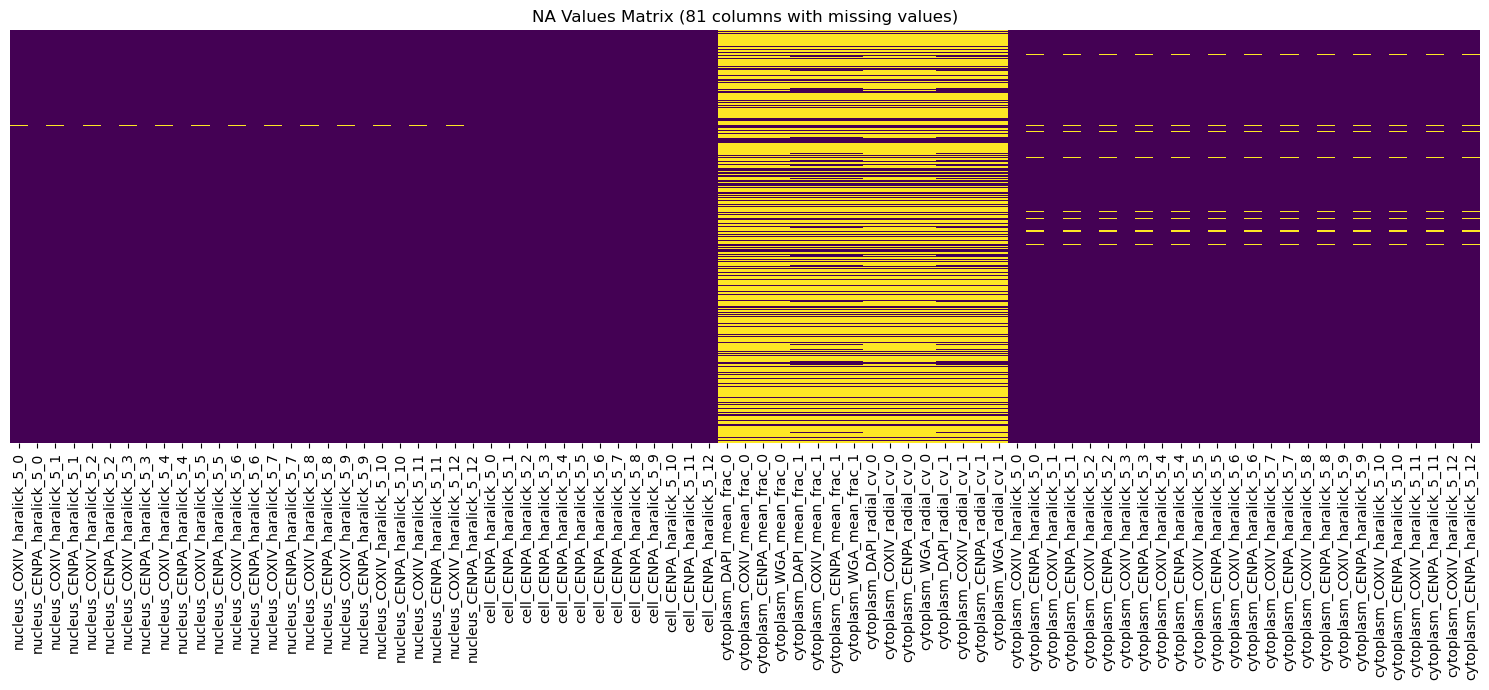

In [15]:
metadata, features = query_filter(metadata, features, FILTER_QUERIES)

metadata, features = perturbation_filter(
    metadata, features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

sumamry_df, fig = nas_summary(features)
sumamry_df[sumamry_df["percent_na"] > 0.1]
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [16]:
DROP_COLS_THRESHOLD = 0.1
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [17]:
# Filter by missing values
metadata, features = missing_values_filter(
    metadata,
    features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

metadata.shape, features.shape

Dropping 16 columns with ≥10.0% missing values
Dropped 36 rows with ≥1.0% missing values
Imputing 39 columns with remaining missing values using batched KNN
Imputing for batch 1 with 431 NA rows


((20523, 37), (20523, 1633))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [18]:
CONTAMINATION = 0.01

In [19]:
# Filter by intensity outliers
metadata, features = intensity_filter(
    metadata,
    features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

metadata.shape, features.shape

((20317, 37), (20317, 1633))

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.

The following parameter is only needed if you want your controls to have different perturbation names. Otherwise, can leave this as `None`.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations.

In [20]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting"
PERTURBATION_ID_COL = "sgRNA_0"

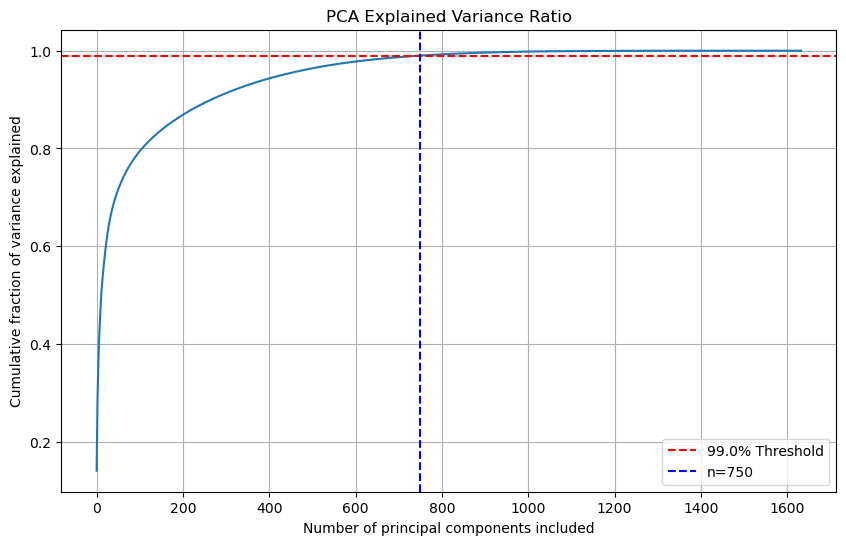

In [21]:
features, metadata = prepare_alignment_data(
    metadata, features, BATCH_COLS, PERTURBATION_NAME_COL, CONTROL_KEY, PERTURBATION_ID_COL
)

n_components, fig = pca_variance_plot(
    features, variance_threshold=0.99
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
    Defaults to 128 (n_components). If between 0 and 1, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified. Note that we use 50,000 cells to estimate number of features if a percentage is specified.
    If 1, a single component is kept, and if None, all components are kept.
    `0.99` is recommended method.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `mean`.

In [22]:
VARIANCE_OR_NCOMP = 0.99
AGG_METHOD = "median"

In [23]:
pca_embeddings = embed_by_pca(
    features, metadata, variance_or_ncomp=VARIANCE_OR_NCOMP, batch_col="batch_values"
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(
/lab/barcheese01/rkern/aggregate_overhaul/brieflow-analysis/brieflow/workflow/lib/aggregate/align.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(


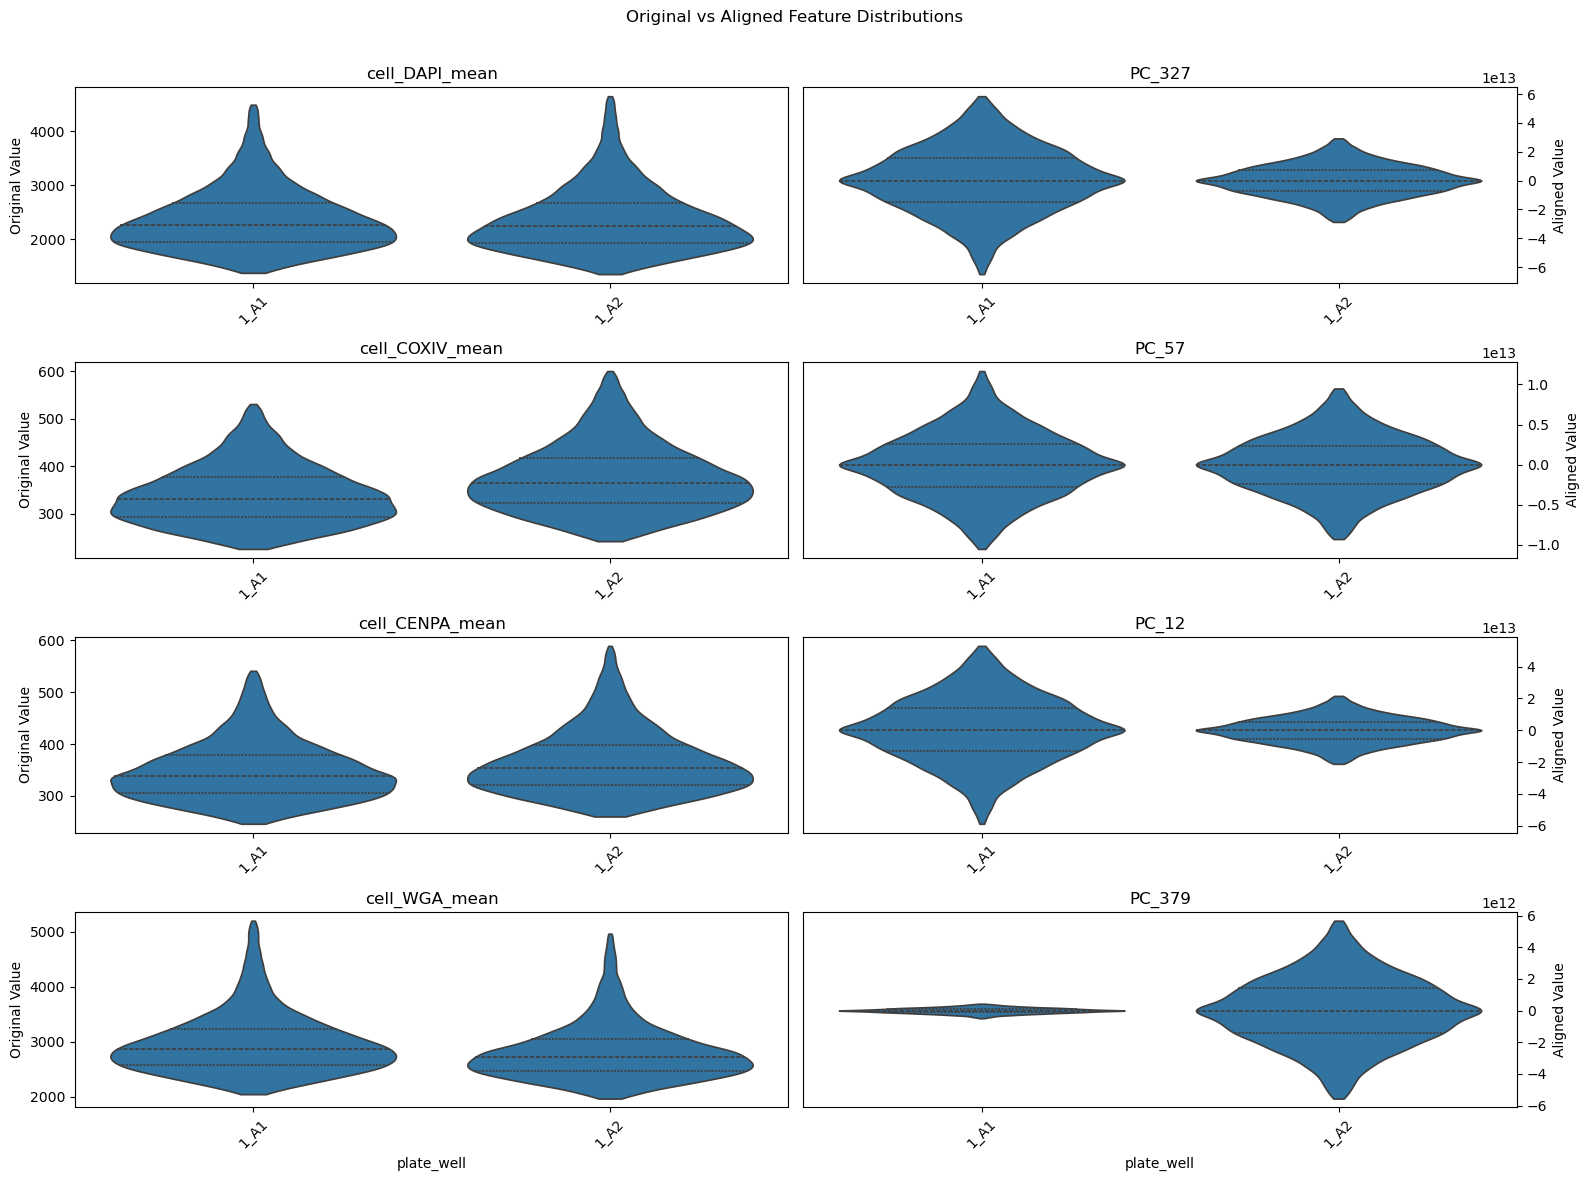

In [24]:
original_feature_cols = [col for col in dataset_features.columns if ("cell_" in col and col.endswith("_mean"))]
pc_cols = [col for col in aggregated_cell_data.columns if col.startswith("PC_")]
aligned_feature_cols = random.sample(pc_cols, k=min(len(original_feature_cols), len(pc_cols)))

original_cell_data = pd.concat([dataset_metadata, dataset_features], axis=1)
original_cell_data

feature_distributions_fig = plot_feature_distributions(
    original_feature_cols,
    original_cell_data,
    aligned_feature_cols,
    aligned_cell_data,
)
plt.show()

## Add aggregate parameters to config file

In [25]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "agg_method": AGG_METHOD,
}

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)